In [45]:
import os
import numpy as np
from glob import glob
from lungstage.io import walk_all_npz, read_annotated_npz
from pyqae.nd import change_resolution_array
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def get_strides(steps,size,offset,VOXEL_SIZE):
    if steps * VOXEL_SIZE < size - 2*offset:
        #not enough coverage. start and end are modified
        start = (size - steps*VOXEL_SIZE) / 2
        end = size - start - VOXEL_SIZE
    else:
        start = offset
        end = size-VOXEL_SIZE - offset
    return list(np.around(np.linspace(start,end,steps)).astype('int32'))

def img_to_vox(img,VOXEL_SIZE):
    # img = np.clip(img, -1000, 400)
    # img = ((img + 1000.) / (400. + 1000.)).astype('float32')

    #first let's just get the minimum amount of coverage
    samples0 = int(img.shape[0] / float(VOXEL_SIZE)) + 4
    samples1 = int(img.shape[1] / float(VOXEL_SIZE)) + 4
    samples2 = int(img.shape[2] / float(VOXEL_SIZE)) + 4

    ixs0 = get_strides(samples0,img.shape[0],0,VOXEL_SIZE)
    ixs1 = get_strides(samples1,img.shape[1],0,VOXEL_SIZE)
    ixs2 = get_strides(samples2,img.shape[2],0,VOXEL_SIZE)

    subvoxels = []
    locations = []
    centroids = []
    for i0,x0 in enumerate(ixs0):
        for i1,x1 in enumerate(ixs1):
            for i2,x2 in enumerate(ixs2):
                subvoxels.append(img[x0:x0+VOXEL_SIZE,x1:x1+VOXEL_SIZE,x2:x2+VOXEL_SIZE])
                assert subvoxels[-1].shape == (VOXEL_SIZE,VOXEL_SIZE,VOXEL_SIZE), 'bad subvoxel shape ' + str(subvoxels[-1].shape) + ' ' + str([x0,x1,x2]) + ' ' + str(img.shape)
                locations.append((i0,i1,i2))
                centroids.append((x0+VOXEL_SIZE/2,x1+VOXEL_SIZE/2,x2+VOXEL_SIZE/2))
    X = np.stack(subvoxels, axis=0)
    #print 'num subvoxels:', X.shape[0]
    X = np.expand_dims(X, 1)
    #normalized locations
    #allows us to de-weight certain places...

    return X,locations,centroids
def transform_ct(in_npz):
    img =  ((in_npz.ct_img + 1000.) / (400. + 1000.)).astype('float32')
    return img_to_vox(img, VOXEL_SIZE=64)


In [12]:
from glob import glob
test_scans = walk_all_npz(glob(os.path.join('..', 'lung*', 'data'))[0], 
             strict = False)
c_scan = read_annotated_npz(test_scans[0])

Found #420 patients named:../lungstage_notebooks/data/lung_rois/TNM_StagingD20170214T181751334272_by_Alex_of_ACC24349066.npz


In [26]:
t_scan = c_scan._replace(
    ct_img = change_resolution_array(c_scan.ct_img,old_vox_size=c_scan.vox_size, new_vox_size=.5)[0]
)

/Users/mader/anaconda/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [28]:
vox, locs, cents = transform_ct(t_scan)

In [30]:
vox.shape

(1625, 1, 64, 64, 64)

In [32]:
from keras.models import load_model
node_model = load_model('trained_node_model.h5')

/Users/mader/anaconda/lib/python3.5/site-packages/keras/engine/topology.py:1242: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


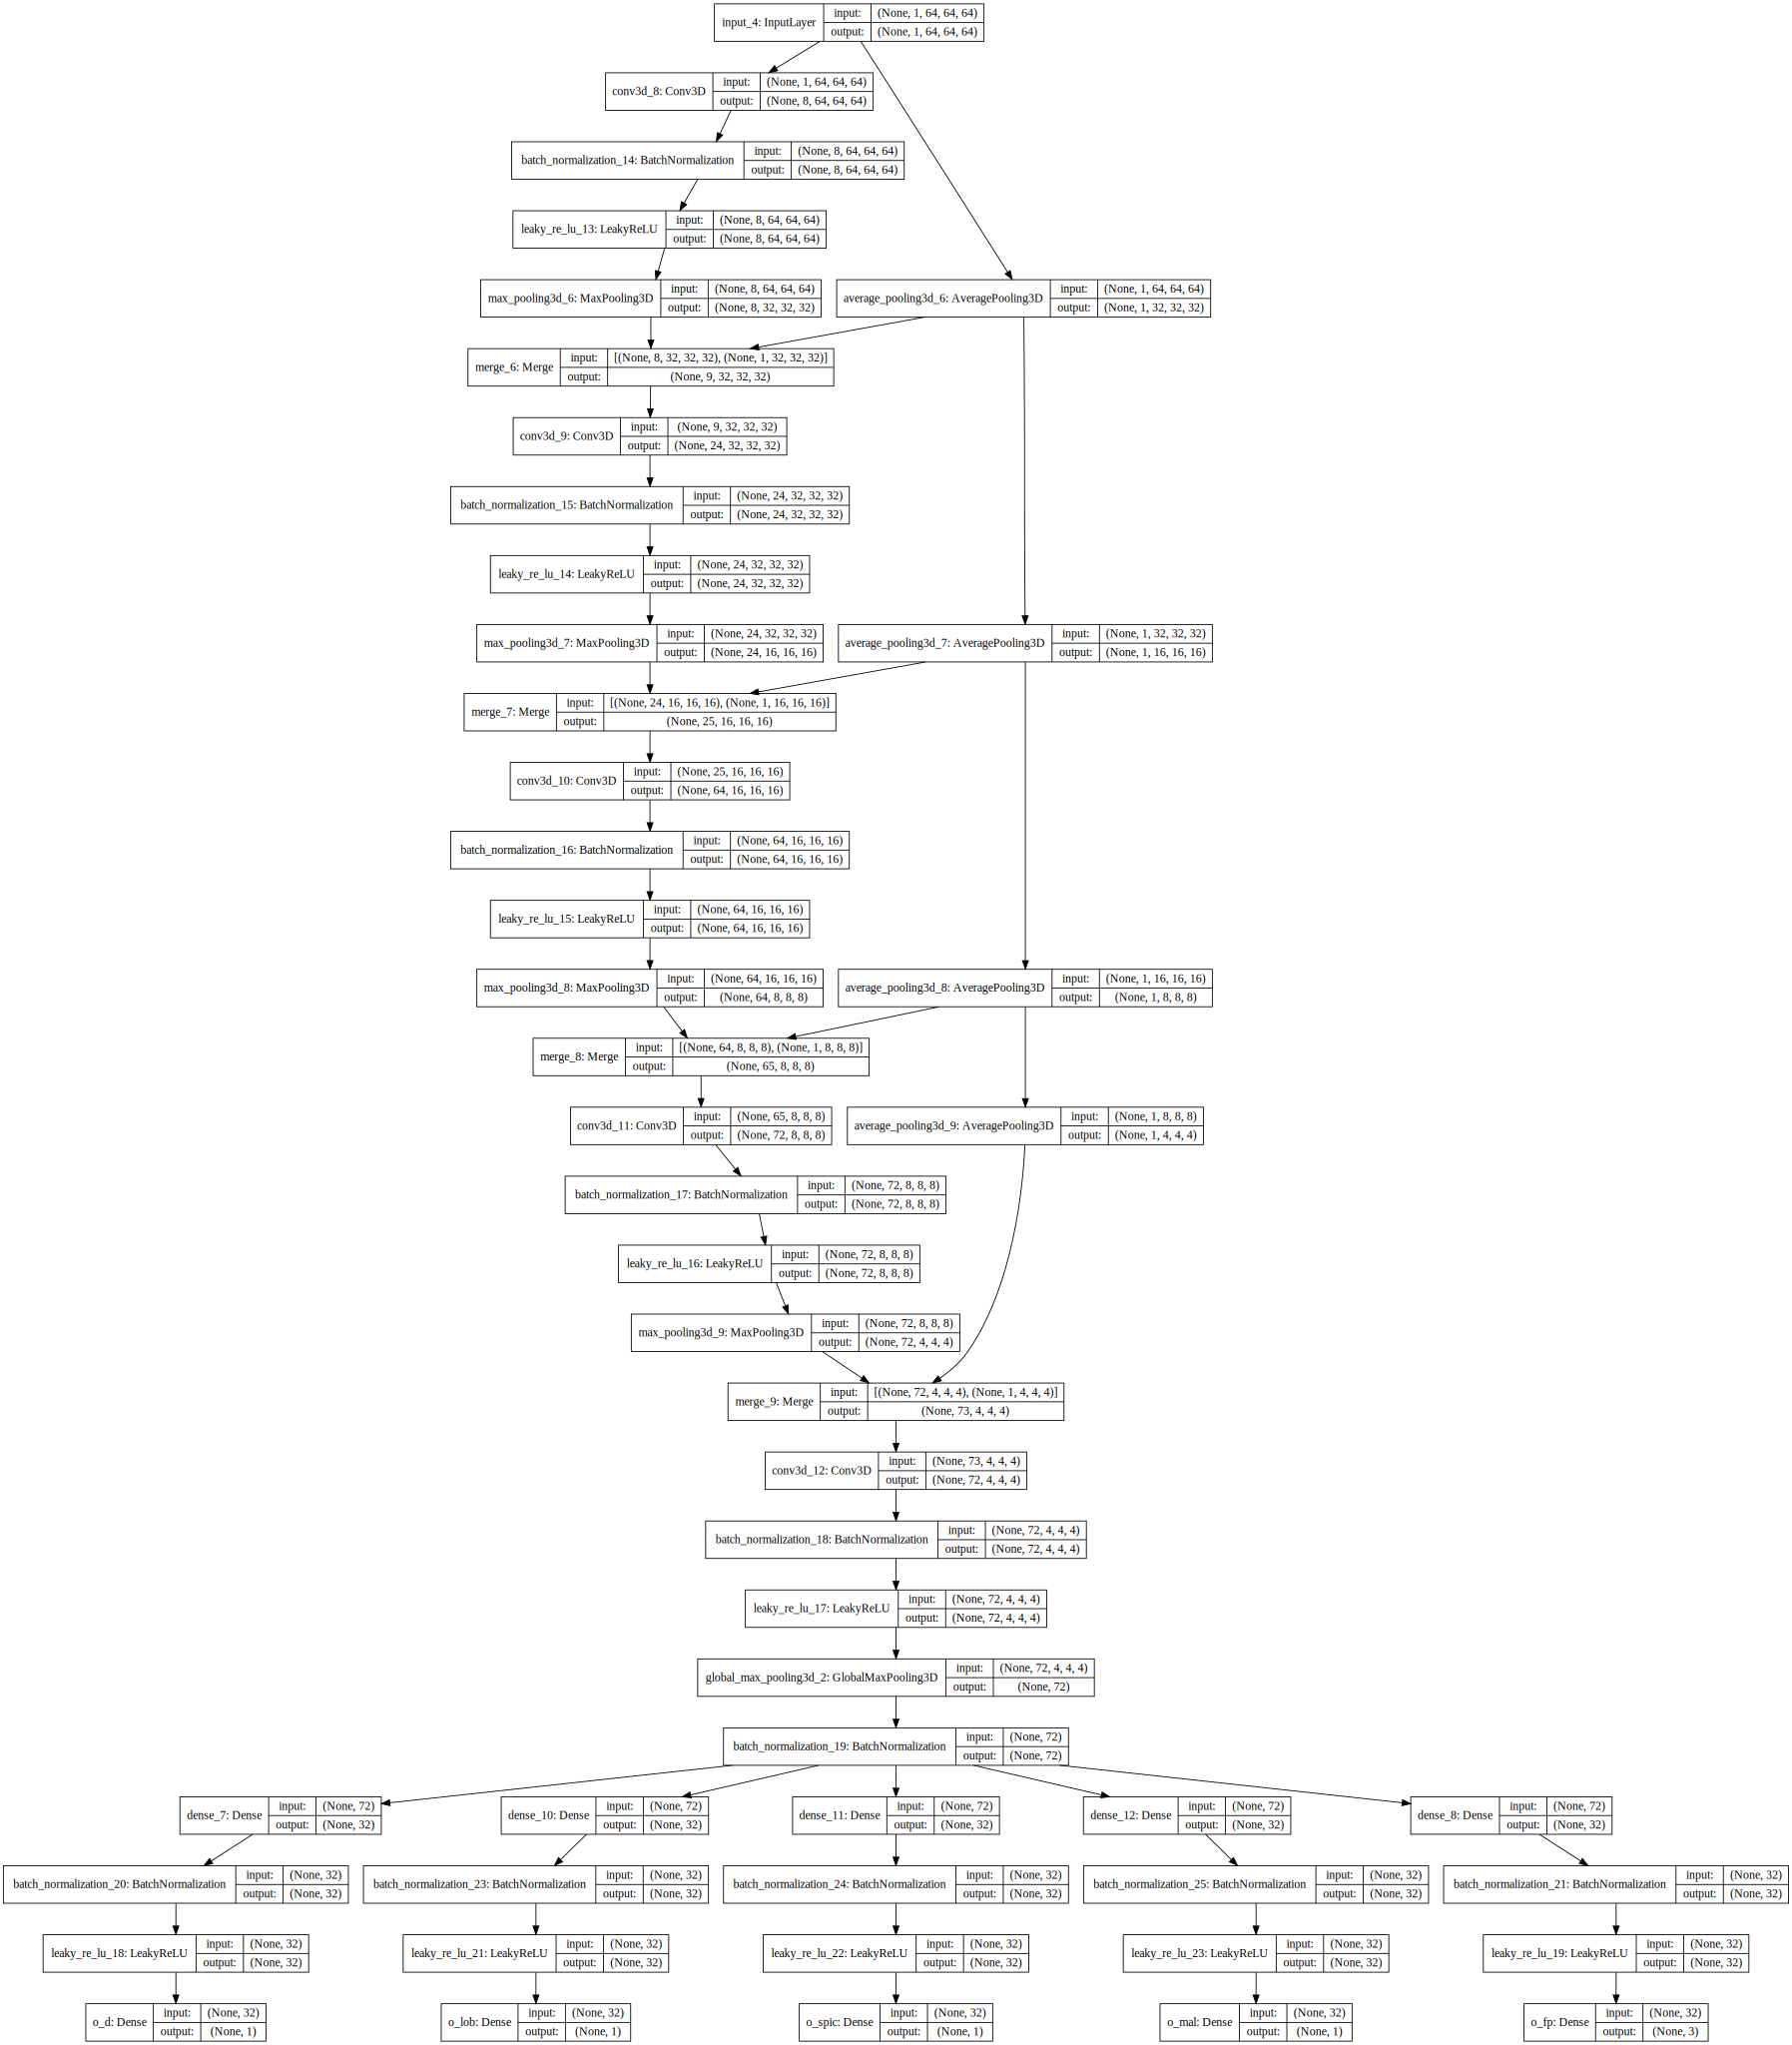

In [34]:
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
def show_net(in_mod, name):
    out_model = model_to_dot(in_mod, show_shapes=True, show_layer_names=True)
    out_model.write_svg(name)
    return SVG(name)
show_net(node_model, 'simple_node_model.svg')

In [35]:
node_pred = node_model.predict(vox, batch_size=4, verbose = 1)

1625/1625 [==============================] - 1513s  


In [36]:
def get_interesting_ixs(preds):
    #return the indices of interest
    ixs = []
    for i in range(preds.shape[0]):
        if preds[i,0] > 5:
            ixs.append(i)
        elif preds[i,1] > 0.3:
            ixs.append(i)
        elif preds[i,2] > 0.3:
            ixs.append(i)
        elif preds[i,3] > 0.3:
            ixs.append(i)

    if len(ixs) == 0:
        ixs = [np.argmax(preds[:,3])]
    return np.array(ixs)

In [41]:
if type(node_pred) == list:
    node_pred = np.concatenate(node_pred,axis=1)

topNixs = get_interesting_ixs(node_pred)

topNvox = vox[topNixs]
topNcentroids = np.array(cents)[topNixs]


print(topNvox, topNcentroids, [vox.shape] * topNcentroids.shape[0])

[[[[[ 0.64571428  0.64571428  0.68357146 ...,  0.12428571  0.14        0.14      ]
    [ 0.6857143   0.6857143   0.69571429 ...,  0.18928571  0.12571429
      0.12571429]
    [ 0.6857143   0.6857143   0.69571429 ...,  0.18928571  0.12571429
      0.12571429]
    ..., 
    [ 0.71928573  0.71928573  0.72857141 ...,  0.74714285  0.72000003
      0.72000003]
    [ 0.71928573  0.71928573  0.72857141 ...,  0.74714285  0.72000003
      0.72000003]
    [ 0.71928573  0.71928573  0.72857141 ...,  0.74714285  0.72000003
      0.72000003]]

   [[ 0.63285714  0.63285714  0.65428573 ...,  0.10071429  0.13428572
      0.13428572]
    [ 0.65499997  0.65499997  0.65142858 ...,  0.10928571  0.07857143
      0.07857143]
    [ 0.65499997  0.65499997  0.65142858 ...,  0.10928571  0.07857143
      0.07857143]
    ..., 
    [ 0.73857141  0.73857141  0.73928571 ...,  0.59214288  0.63        0.63      ]
    [ 0.73857141  0.73857141  0.73928571 ...,  0.59214288  0.63        0.63      ]
    [ 0.73857141  0.73857

In [42]:
topNixs

array([  14,   68,  133,  146,  159,  216,  223,  224,  225,  231,  243,
        251,  263,  264,  269,  270,  277,  290,  303,  393,  484,  505,
        548,  556,  561,  563,  567,  576,  581,  588,  589,  594,  595,
        602,  608,  732,  757,  776,  777,  789,  816,  830,  835,  836,
        861,  869,  874,  875,  876,  881,  892,  893,  901,  905,  906,
        907,  913,  914,  919,  920, 1057, 1089, 1090, 1101, 1102, 1108,
       1114, 1119, 1121, 1126, 1127, 1133, 1134, 1147, 1174, 1199, 1201,
       1212, 1213, 1217, 1226, 1230, 1245, 1382, 1427, 1459, 1472, 1499,
       1504, 1512, 1522, 1526, 1542, 1551, 1555])

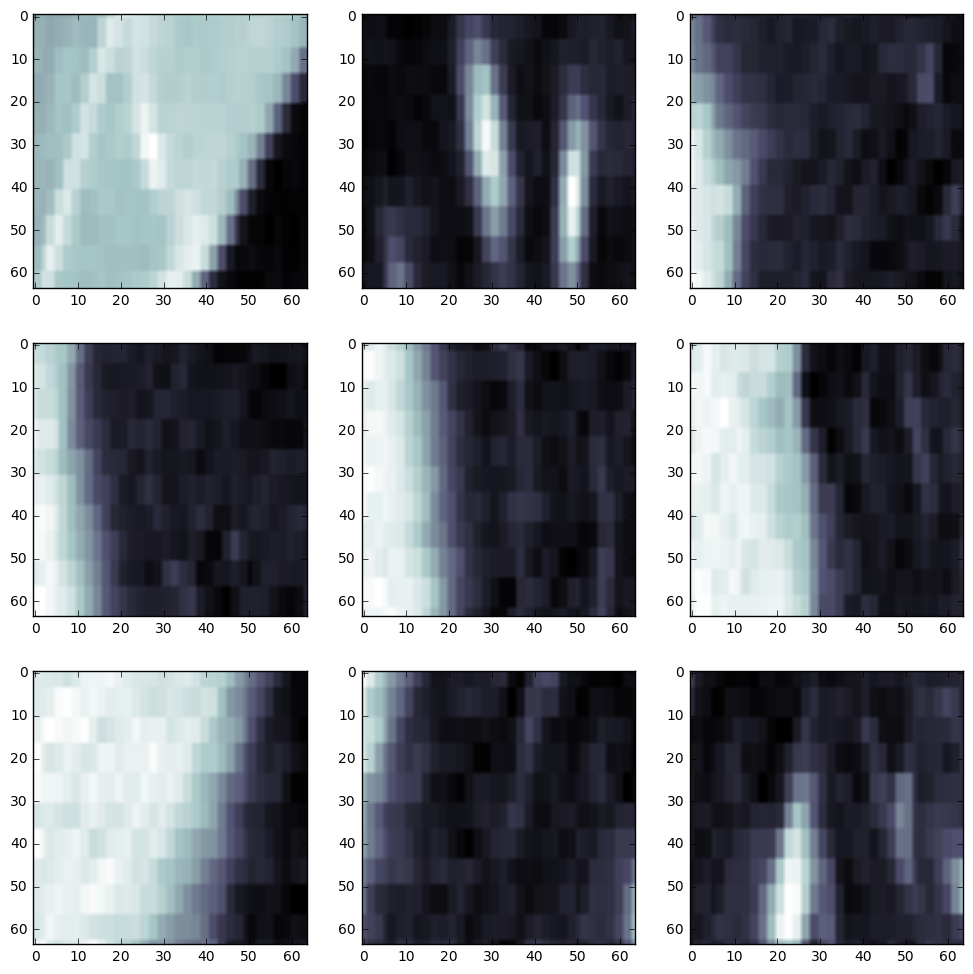

In [47]:
fig, c_axs = plt.subplots(3,3, figsize = (12,12))
for c_vol, c_ax in zip(topNvox, c_axs.flatten()):
    c_ax.imshow(c_vol[0, 32, :, :], cmap = 'bone')